# SIGNIFICATO COLONNE DATASET:
**- Price: il prezzo, il target da prevedere**
- Area: superficie dell’immobile
- Bedrooms: numero di camere da letto
- Bathrooms: numero di bagni
- Stories: numero di piani
- Mainroad: vale 1 se l’immobile affaccia su una strada principale, 0 altrimenti
- Guestroom: vale 1 se l’immobile ha una stanza degli ospiti, 0 altrimenti
- Basement: vale 1 se l’immobile ha un seminterrato, 0 altrimenti
- Hotwaterheating: vale 1 se l’immobile ha una caldaia, 0 altrimenti
- Airconditioning: vale 1 se l’immobile ha l’aria condizionata, 0 altrimenti
- Parking: numero di parcheggi
- Prefarea: vale 1 se l’immobile è in una zona prestigiosa, 0 altrimenti
- Furnishingstatus: vale 0 se l’immobile non è arredato, 1 se è parzialmente arredato, 2 se è completamente arredato

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_SEED = 0

In [3]:
BASE_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/"

In [4]:
df = pd.read_csv(BASE_URL + "housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


In [5]:
# Check di alcuni dati:
df.shape # 545 osservazioni, 13 features
df.isna().sum() # Nessun valore mancante
df.info() # Le variabili delle features sono tutte numeriche (alcune già binarie tra l'altro)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


## 1. STANDARDIZZAZIONE

In [6]:
X = df.drop("price", axis=1).values
y = df["price"].values

X.shape, y.shape

((545, 12), (545,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [8]:
# Standardizzo:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [9]:
# CHECK:
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Media X_train post standard.: {X_train.mean(axis=0).round(10)}") # OK
print(f"Deviazione standard per X_train: {X_train.std(axis=0).round(10)}") # OK

Training set: (381, 12)
Test set: (164, 12)
Media X_train post standard.: [-0.  0. -0. -0. -0.  0. -0.  0.  0.  0. -0. -0.]
Deviazione standard per X_train: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 2. CREAZIONE MODELLI DI REGRESSIONE

In [48]:
# DEFINISCO UNA FUNZIONE "COMUNE" PER TUTTI E 3 I MODELLI, IN MODO DA EVITARE CODICE RIDONDANTE.

# OSS: anche se la traccia non la richiede, calcolo anche l'R2:

def evaluate_model(model, X_train, y_train, X_test, y_test):
  # Previsione sul set di test:
  y_pred = model.predict(X_test)

  # Sia il mean_squared_error che il r2_score li calcolo sia sul test di set (x vedere quanto bene il modello generalizza
  # su dati che non ha mai vistos), sia l'MSE sul train set tramite validazione incrociata su 5 fold (= x def. il modello viene quindi
  # addestrato su 4/5 dei dati e testato sull'1/5, per 5 volte => ALLA FINE FA LA MEDIA)
  mse_train = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()
  mse_test = mean_squared_error(y_test, y_pred)
  r2_train = cross_val_score(model, X_train, y_train, cv=5, scoring="r2").mean()
  r2_test = r2_score(y_test, y_pred)

  # CALCOLO DEI COEFFICIENTI NON NULLI:
  non_null_coefs = np.sum(np.abs(model.coef_) > 1e-10)
  total_coefs = len(model.coef_)
  print(f"Coefficienti non nulli: {non_null_coefs} / {total_coefs}")

  # In una futura implementazione, potrei anche mettere un ciclo if..else di controllo su EVENTUALI coeff. nulli

  # METTO I RISULTATI IN UN DIZIONARIO:
  risultati = {
      "mse_train": mse_train,
      "mse_test": mse_test,
      "r2_train": r2_train,
      "r2_test": r2_test,
      "non_null_coefs": non_null_coefs,
      "total_coefs": total_coefs
  }


  return risultati

Da ricordare che Sci-Kit Learn restituisce il valore negativo dell'MSE, in quanto di default tende a massimizzare i punteggi.

Per definizione, però, l'MSE deve essere minimizzato; ecco perché si usa il -.

In [11]:
# LASSO:
lasso = Lasso(alpha= 0.1)
lasso.fit(X_train, y_train)
evaluate_model(lasso, X_train, y_train, X_test, y_test) #MSE ABBASTANZA ALTI, ma è normale visto il target. L'MSE sul set train è < del train set..

# R2 sul set di test di 0.72 => modello buono
# 12 coefficienti totali, tutti diversi da 0 -> il modello ha considerato correttamente tutte le feature

Coefficienti non nulli: 12 / 12


{'mse_train': np.float64(1301414802946.2195),
 'mse_test': 961886997102.6257,
 'r2_train': np.float64(0.624653684874497),
 'r2_test': 0.7227012055821017,
 'non_null_coefs': np.int64(12),
 'total_coefs': 12}

Il r2_score sul training set è di 0.62; ciò significa che il modello spiega circa il 62% della varianza nei dati di training; in pratica, il modello ha una buona (ma non eccellente) capacità esplicativa sui dati che vede durante l'addestramento.

Invece, sul test set l'r2_score è di 0.72 e, come commentato anche nello script, suggerisce che il modello generalizza bene (circa il 72% della varianza).

Infine, gli MSE sono molto alti (dovuti al valore del target ovviamente), ma quello che ci interessa è il CONFRONTO tra i vari modelli, non il valore assoluto.

In [12]:
# RIDGE:
ridge = Ridge(alpha= 1.0)
ridge.fit(X_train, y_train)
evaluate_model(ridge, X_train, y_train, X_test, y_test) # R2 sul set di test di 0.726 => modello buono

Coefficienti non nulli: 12 / 12


{'mse_train': np.float64(1300967026655.7612),
 'mse_test': 961436118597.6902,
 'r2_train': np.float64(0.6248172707546693),
 'r2_test': 0.722831187655073,
 'non_null_coefs': np.int64(12),
 'total_coefs': 12}

Qui ho scelto alpha=1.0 riprendendo anche un po' il valore utilizzato nella pratica, e, esattamente come ci ha insegnato il prof., non c'è molta differenza rispetto al Lasso.

In [18]:
# ELASTIC-NET:
elastic = ElasticNet(alpha= 1.0, l1_ratio= 0.5)
elastic.fit(X_train, y_train)
evaluate_model(elastic, X_train, y_train, X_test, y_test)  # R2 di 0.66 => Modello discreto -> È il modello migliore tra i 3

Coefficienti non nulli: 12 / 12


{'mse_train': np.float64(1358262694990.7476),
 'mse_test': 1016384763294.2836,
 'r2_train': np.float64(0.6124312302297664),
 'r2_test': 0.7069902489843561,
 'non_null_coefs': np.int64(12),
 'total_coefs': 12}

---------

# 3. VISUALIZZAZIONE DEI RISULTATI

Innanzitutto, andiamo a tracciare per completezza le LEARNING CURVES per ogni modello.

In [14]:
sns.set_theme()

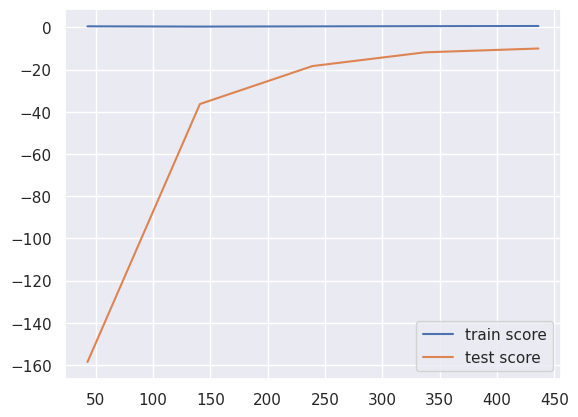

In [15]:
# LASSO:
train_size_abs_lasso, train_score_lasso, test_score_lasso = learning_curve(
    Lasso(),
    X, y,
    random_state = RANDOM_SEED
)

plt.plot(train_size_abs_lasso, train_score_lasso.mean(axis=1), label="train score")
plt.plot(train_size_abs_lasso, test_score_lasso.mean(axis=1), label="test score")
plt.legend()
plt.show()

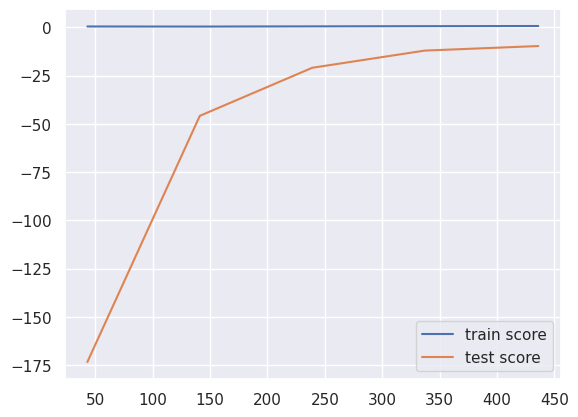

In [16]:
# RIDGE:
train_size_abs_ridge, train_score_ridge, test_score_ridge = learning_curve(
    Ridge(alpha=10.),
    X, y,
    random_state = RANDOM_SEED
)

plt.plot(train_size_abs_ridge, train_score_ridge.mean(axis=1), label="train score")
plt.plot(train_size_abs_ridge, test_score_ridge.mean(axis=1), label="test score")
plt.legend()
plt.show()

Notiamo anche qui che il Lasso e il Ridge hanno performance praticamente identiche, con l'overfitting che da circa 300 osservazioni inizia a ridursi.

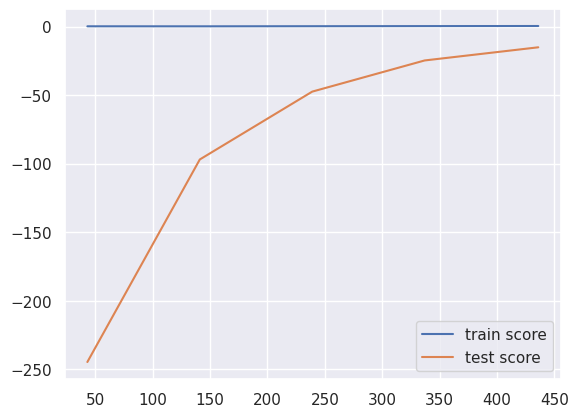

In [17]:
# ELASTIC-NET:
train_size_abs_elastic, train_score_elastic, test_score_elastic = learning_curve(
    ElasticNet(alpha=10., l1_ratio=0.5),
    X, y,
    random_state = RANDOM_SEED
)

plt.plot(train_size_abs_elastic, train_score_elastic.mean(axis=1), label="train score")
plt.plot(train_size_abs_elastic, test_score_elastic.mean(axis=1), label="test score")
plt.legend()
plt.show()

Andiamo ora a graficare gli MSE dei vari modelli per confrontarli tra di loro:

In [21]:
sns.set_theme()

In [ ]:
# Innanzitutto, salvo le metriche di ogni modello in una variabile:
results_ridge = evaluate_model(ridge, X_train, y_train, X_test, y_test)
results_lasso = evaluate_model(lasso, X_train, y_train, X_test, y_test)
results_elastic = evaluate_model(elastic, X_train, y_train, X_test, y_test)

In [23]:
# Per praticità, creo un dataframe con gli MSE:
risultati_df = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "Elastic-Net"],
    "MSE_train": [results_ridge["mse_train"], results_lasso["mse_train"], results_elastic["mse_train"]],
    "MSE_test": [results_ridge["mse_test"], results_lasso["mse_test"], results_elastic["mse_test"]],
    "R2_train": [results_ridge["r2_train"], results_lasso["r2_train"], results_elastic["r2_train"]],
    "R2_test": [results_ridge["r2_test"], results_lasso["r2_test"], results_elastic["r2_test"]],
    "Non_null_coefs": [results_ridge["non_null_coefs"], results_lasso["non_null_coefs"], results_elastic["non_null_coefs"]]
})

risultati_df


,Model,MSE_train,MSE_test,R2_train,R2_test,Non_null_coefs
0,Ridge,1.300967e+12,9.614361e+11,0.624817,0.722831,12
1,Lasso,1.301415e+12,9.618870e+11,0.624654,0.722701,12
2,Elastic-Net,1.358263e+12,1.016385e+12,0.612431,0.706990,12


---------

Per visualizzare graficamente le performance dei modelli, utilizzo seaborn perché più comodo. In particolare, utilizzo innanzitutto il metodo 'melt()' per convertire il formato del DataFrame in modo da visualizzare MSE_train e MSE_set vicini (per lo stesso model ovviamente); in pratica, converto il DF in un formato leggibile per seaborn.

In [34]:
mse_df = risultati_df.melt(
    id_vars="Model",
    value_vars=["MSE_train", "MSE_test"],
    var_name="Set",
    value_name="MSE"
)

Per confrontare quindi gli MSE, utilizzo banalmente un grafico a barre, usando 1 solo metodo di seaborn, ovvero 'barplot'.

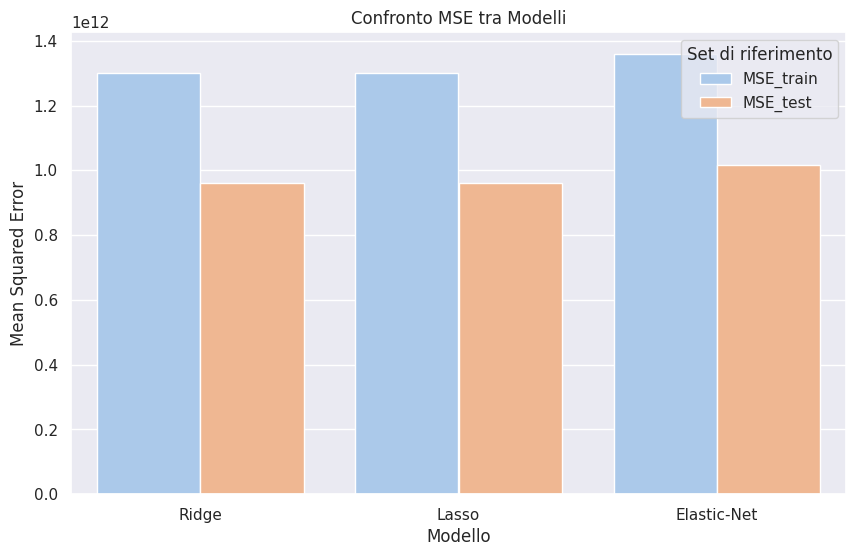

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(data=mse_df, x="Model", y="MSE", hue="Set", palette="pastel") #hue = "Set" colonna le barre in modo diverso le raggruppa per ciascun model

plt.title("Confronto MSE tra Modelli")
plt.xlabel("Modello")
plt.ylabel("Mean Squared Error")
plt.legend(title="Set di riferimento")
plt.show()

OSS: non disegno gli R2 perché non espressivamente richiesti, ma in ogni caso basta cambiare facilmente i value_vars=["MSE_train", "MSE_test"] con R2_train e R2_test.

---------

Infine, passiamo ora a visualizzare la distribuzione dei residui.

Ricordiamo che il residuo è l'errore che indica la differenza tra il valore reale e la previsione effettuata dal modello.

Ricordiamo che, in generale, i residui devono essere distribuiti in modo simmetrico e centrati sullo 0.

In [44]:
# Definiamo quindi una funzione in cui vengono calcolati i residui e mostrati:
def plot_residuals(model, dataset):
  X, y = dataset
  y_pred = model.predict(X)

  residuals = y-y_pred

  plt.scatter(y_pred, residuals) # Grafichiamo i valori previsti con i residui
  plt.axhline(y=0, color="r", linestyle="--")
  plt.xlabel("Valori Previsti")
  plt.ylabel("Residui")
  plt.title("Residui del modello")
  plt.show()

Ai fini dell'esercizio, calcolo i residui solo sul set di test:

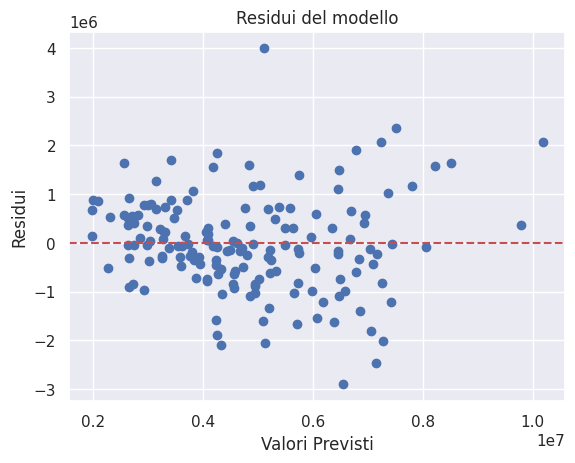

In [45]:
# Iniziamo con il Ridge:
plot_residuals(ridge, (X_test, y_test))

Cosa notiamo per la distribuzione dei residui per il Modello Ridge?

- I residui sono ben bilanciati sopra e sotto lo 0 (linea rossa), quindi il modello non ha un bias "sistematico", nel senso che non tende a sovrastimare o sottostimare in modo evidente.

- Inoltre, non ci sono per fortuna pattern (ex: forme a U, curva, ecc.) -> il modello sembra catturare bene la tendenza centrale.

⚠️ ATTENZIONE PERÒ: i residui tendono ad allargarsi all'aumentare del valore previsto del prezzo => ciò mi indica che il modello tende ad essere meno preciso quando il prezzo della casa aumenta.
Inoltre, ci sono alcuni punti abbastanza distanti dalla linea rossa; ciò mi suggerisce che potrebbero esserci degli appartamenti con caratteristiche "anomale" che il modello non riesce a catturare bene.

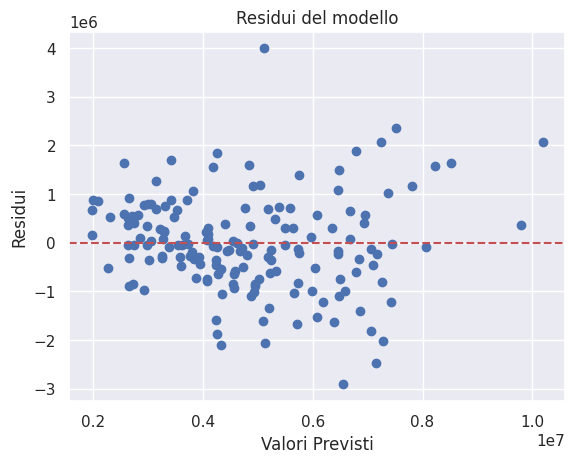

In [46]:
# LASSO:
plot_residuals(lasso, (X_test, y_test))

Anche in questo caso, come avevamo visto per la Learning Curve, i due modelli non differiscono molto.

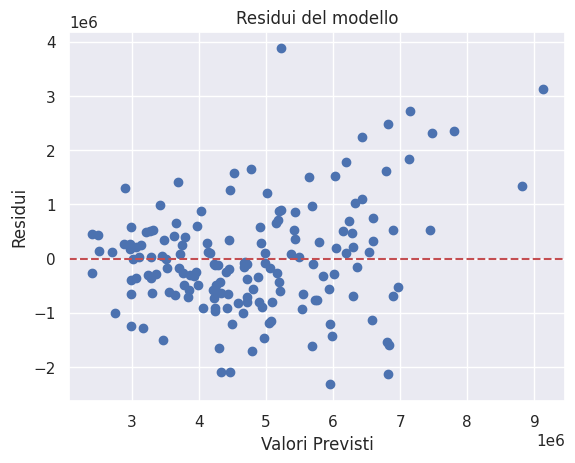

In [47]:
# Elastic-Net:
plot_residuals(elastic, (X_test, y_test))